[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/035_rnn_forecast/rnn_forecast.ipynb)

# Predicción de Series Temporales

En el [post](https://sensioai.com/blog/034_rnn_intro) anterior hemos introducido la arquitectura de `red neuronal recurrente`, útil para aplicaciones en las que trabajamos con datos secuenciales como, por ejemplo, series temporales. Encontramos series temporales en multitud de aplicaciones como financieras (previsión de ventas en empresa, evolución acciones en bolsa, ...), médicas (evolución síntomas paciente, predicción de mortalidad, ...), y muchas otras.

## Prediciendo el último valor

En el post anterior ya vimos un ejemplo de como entrenar una `RNN` para predecir el útlimo valor en una serie temporal a partir de todo el histórico de datos disponibles. Para ilustrar este caso utilizamos un dataset sintético.

In [ ]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

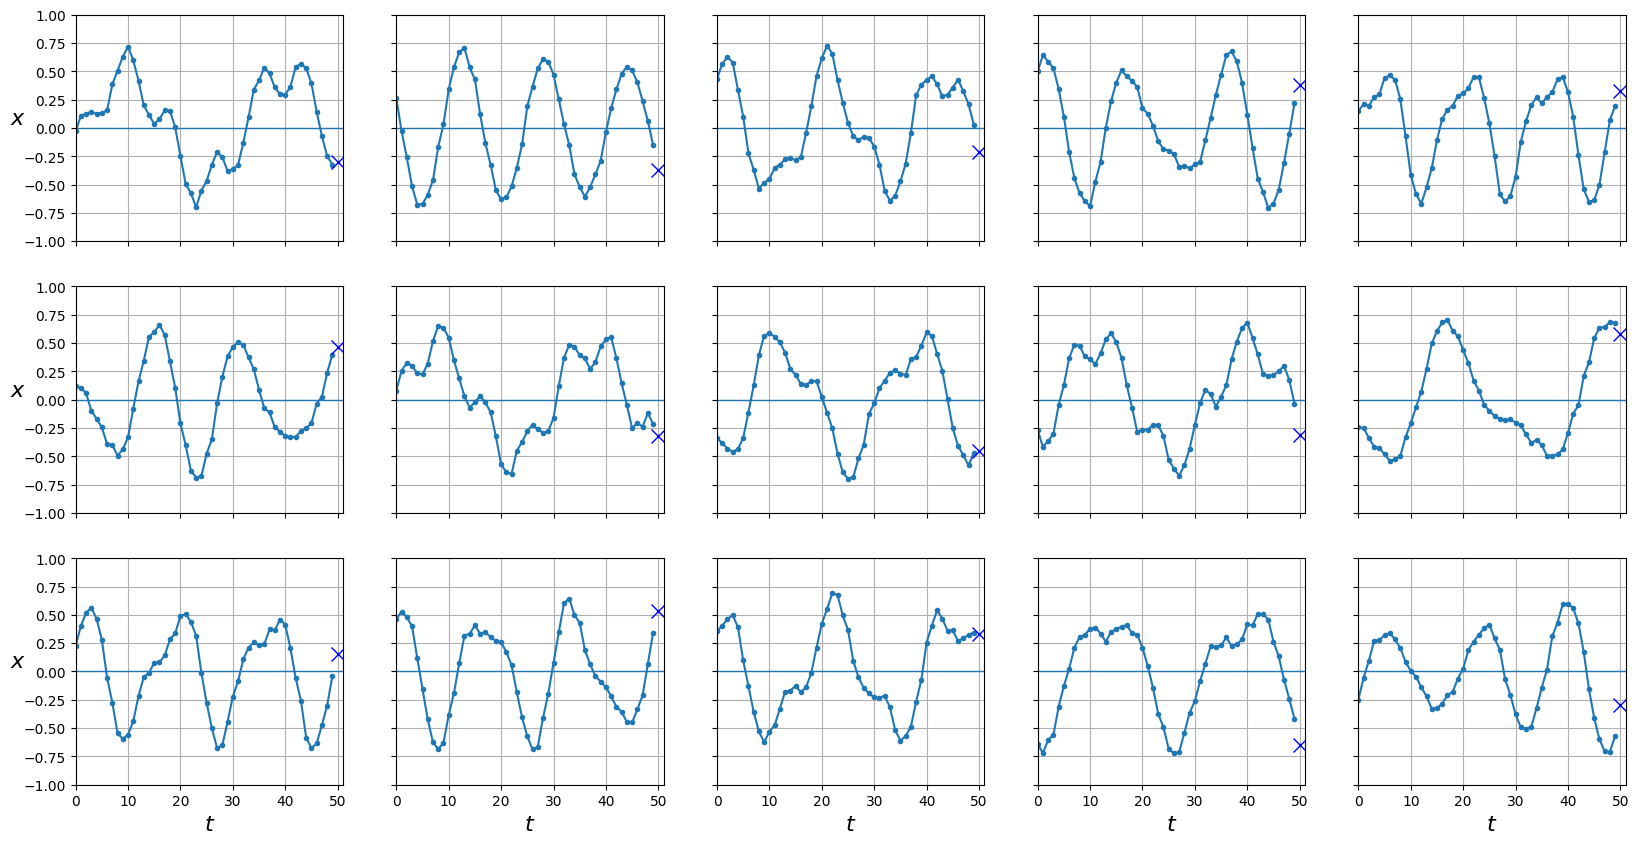

In [ ]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test, y_test)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

Entrenaremos una `red recurrente` que aceptará un único valor a la entrada, el cual estará conectado a 20 neuronas en la capa oculta. Los 20 valores obtenido en el último instante temporal, serán conectados con una neurona para producir el valor final que buscamos.

In [ ]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x)
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [ ]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [ ]:
fit(rnn, dataloader)

loss 0.00392 val_loss 0.00381: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


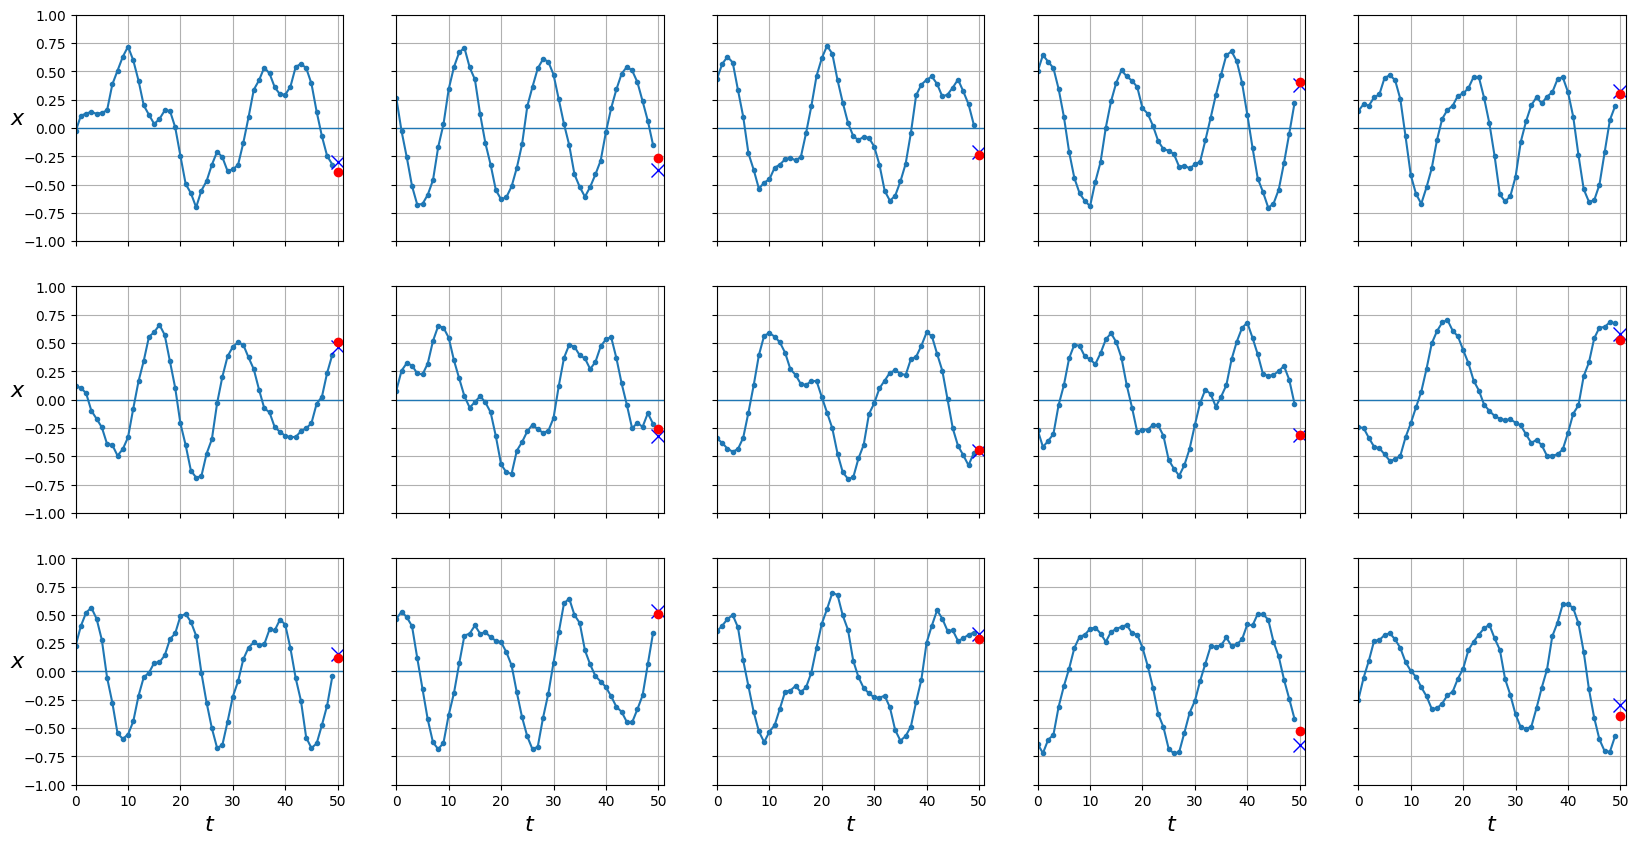

0.004134917

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

Podemo mejorar este modelo añadiendo más capas ocultas en lo que se conoce como una `red neuronal recurrente profunda`.

![](https://static.packt-cdn.com/products/9781787121089/graphics/image_06_008.png)

Como ya hemos hablado en posts anteriores, esto incrementará la capacidad de nuestro modelo que puede (o no) mejorar las prestaciones de nuestro modelo.

> 💡 Puedes aprender más sobre la capacidad de un modelo y saber si mejorará o no las prestaciones en este [post](https://sensioai.com/blog/030_data_splitting).

Puedes controlar el número de capas ocultas en tu `RNN` con el parámetro `num_layers`. Cada capa oculta tendrá conexiones a las salidas de la capa anterior así como las salidas de ella misma en el instante anterior.

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x)
    x = self.fc(x[:,-1])
    return x

In [ ]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.00350 val_loss 0.00335: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


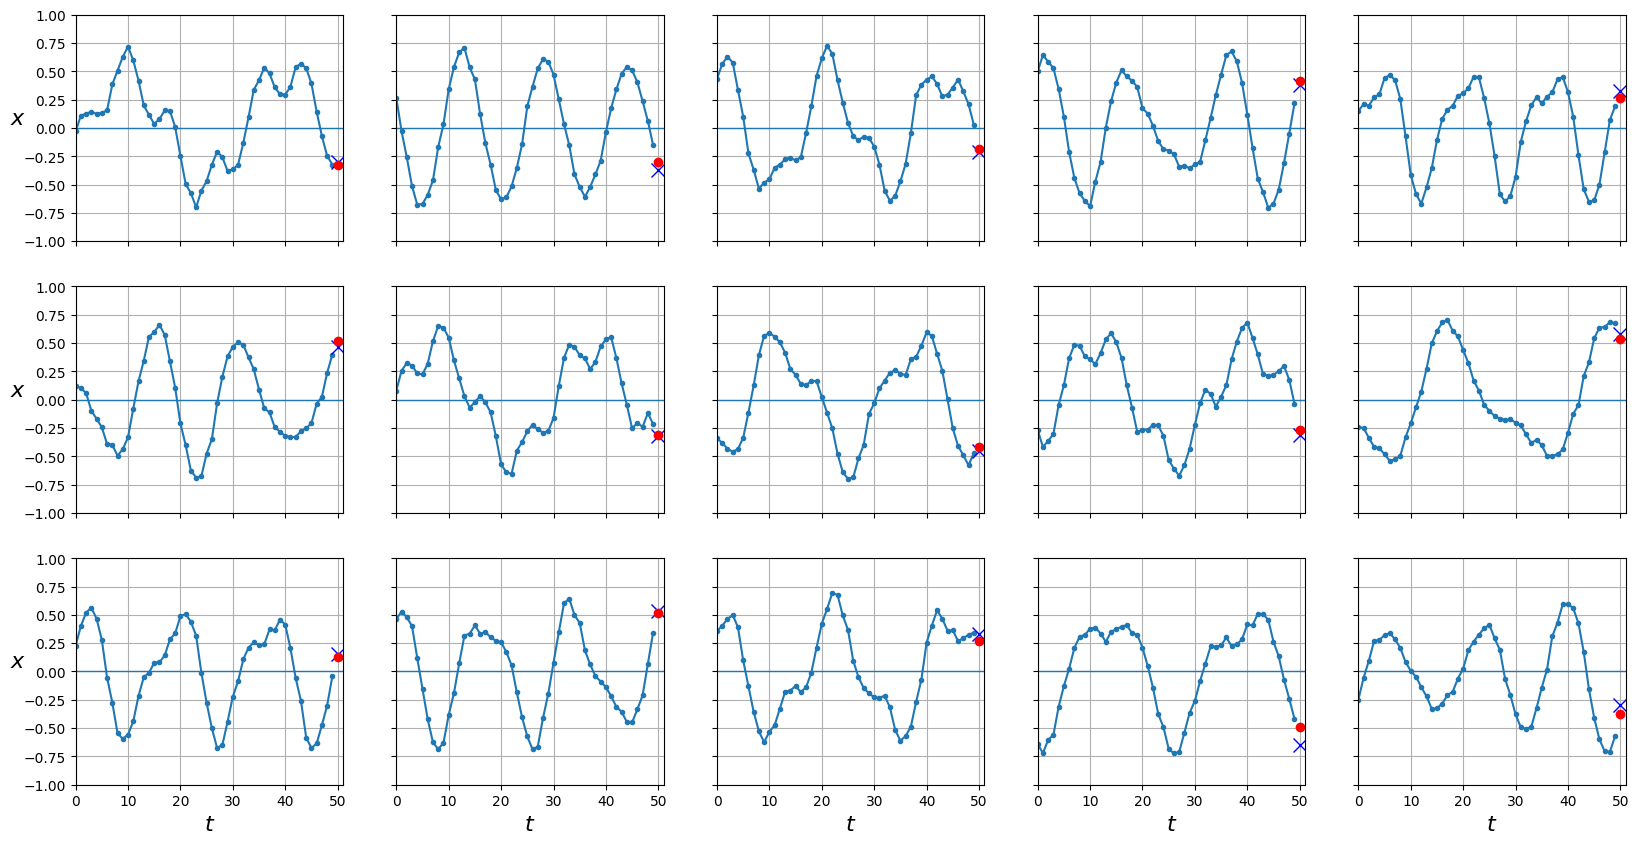

0.0034817148

In [ ]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

## Prediciendo varios valores

Si bien la predicción del último valor en una serie temporal nos ha servido para entender el funcionamiento de una `RNN`, este caso de aplicación no es muy útil. Poder predecir los valores durante una semana entera, un mes e incluso un año puede aportar mucho más valor a la aplicación en cuestión. Vamos a ver cómo predecir los últimos 10 valores en la serie temporal a partir del histórico disponible.

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

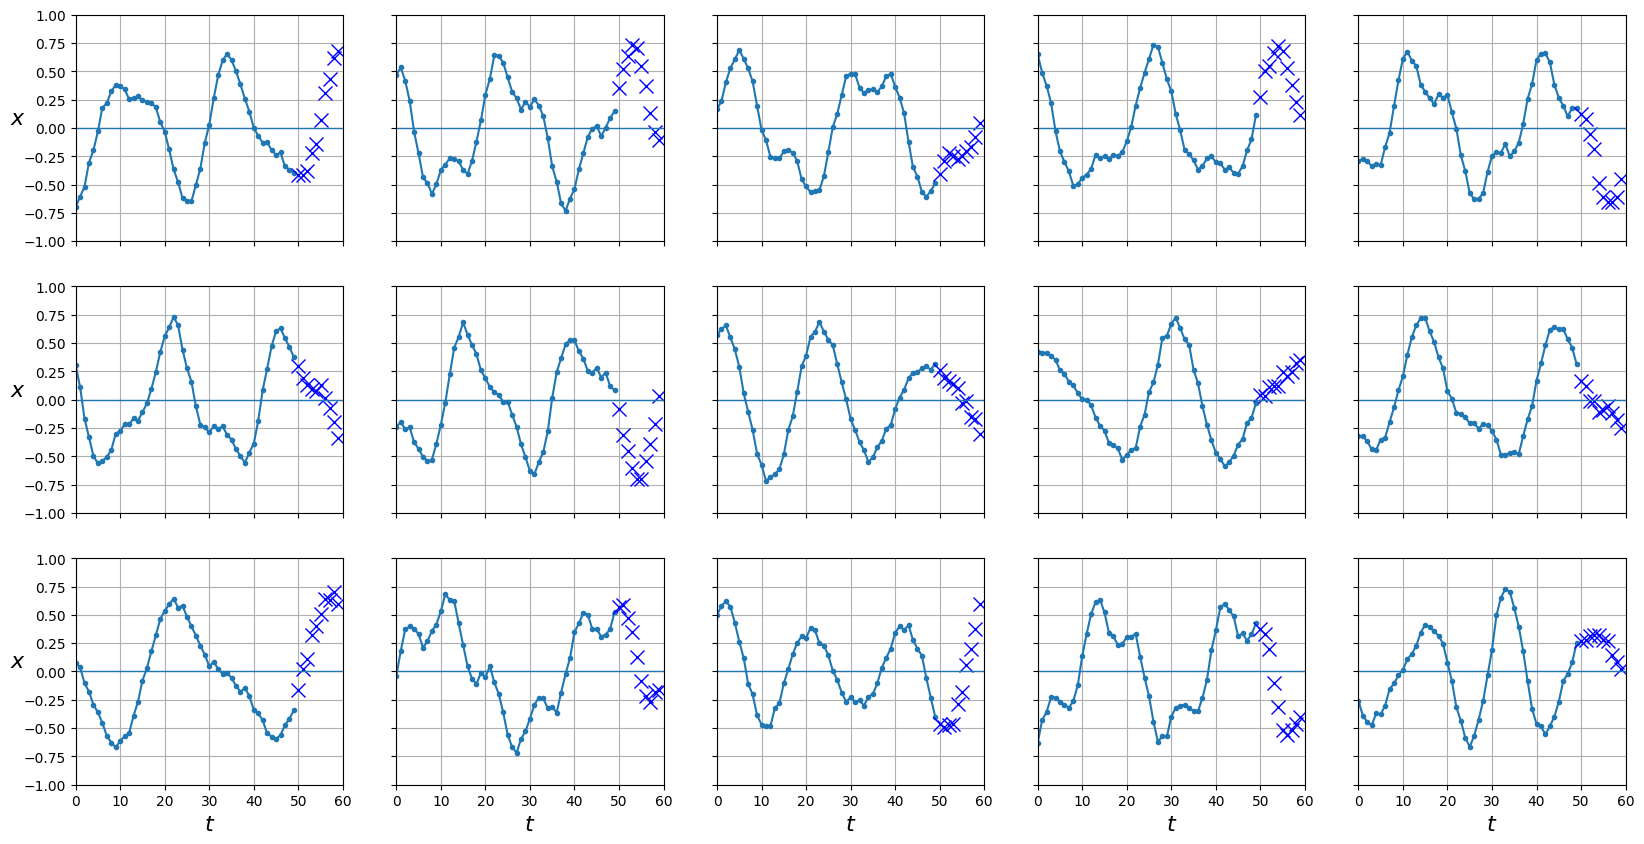

In [ ]:
plot_series(X_test, Y_test)

Podemos probar a utilizar nuestro modelo de `RNN` para esta tarea ya que éste es capaz de predecir el último valor. El truco consiste en que cada vez que predecimos un valor, lo añadimos como parte de los *inputs* y predecimos el siguiente hasta que queramos.

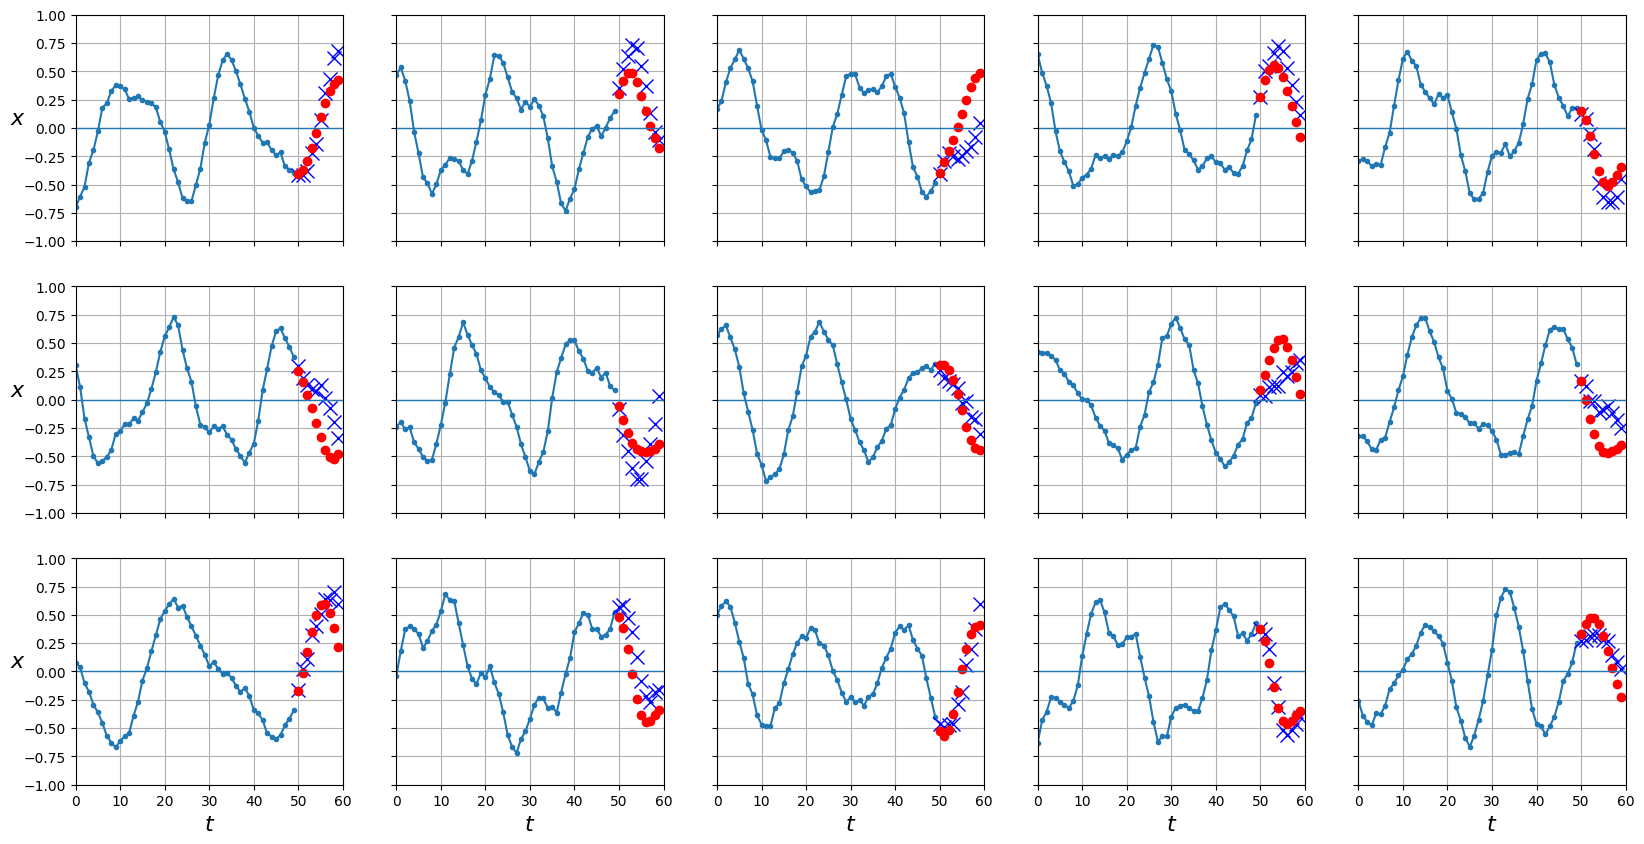

0.04012371

In [ ]:
X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)
    y_pred_one = predict(rnn, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, Y_test, y_pred)
mean_squared_error(Y_test, y_pred)

Si bien este método es útil, y de hecho es usado en multitud de aplicaciones, cualquier error que nuestro modelo tenga será propagado en predicciones consecutivas. Esto lo podemos observar en el hecho que nuestras predicciones son mucho más precisas en los primeros instantes temporales que predecimos, pero se degradan conforme hacemos más predicciones en el futuro. Podemos mejorar nuestros resultados haciendo que nuestro modelo prediga, para cada instante, los 10 siguientes en vez de sólo 1.

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    x = self.fc(x[:,-1])
    return x

In [ ]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.02281 val_loss 0.02075: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


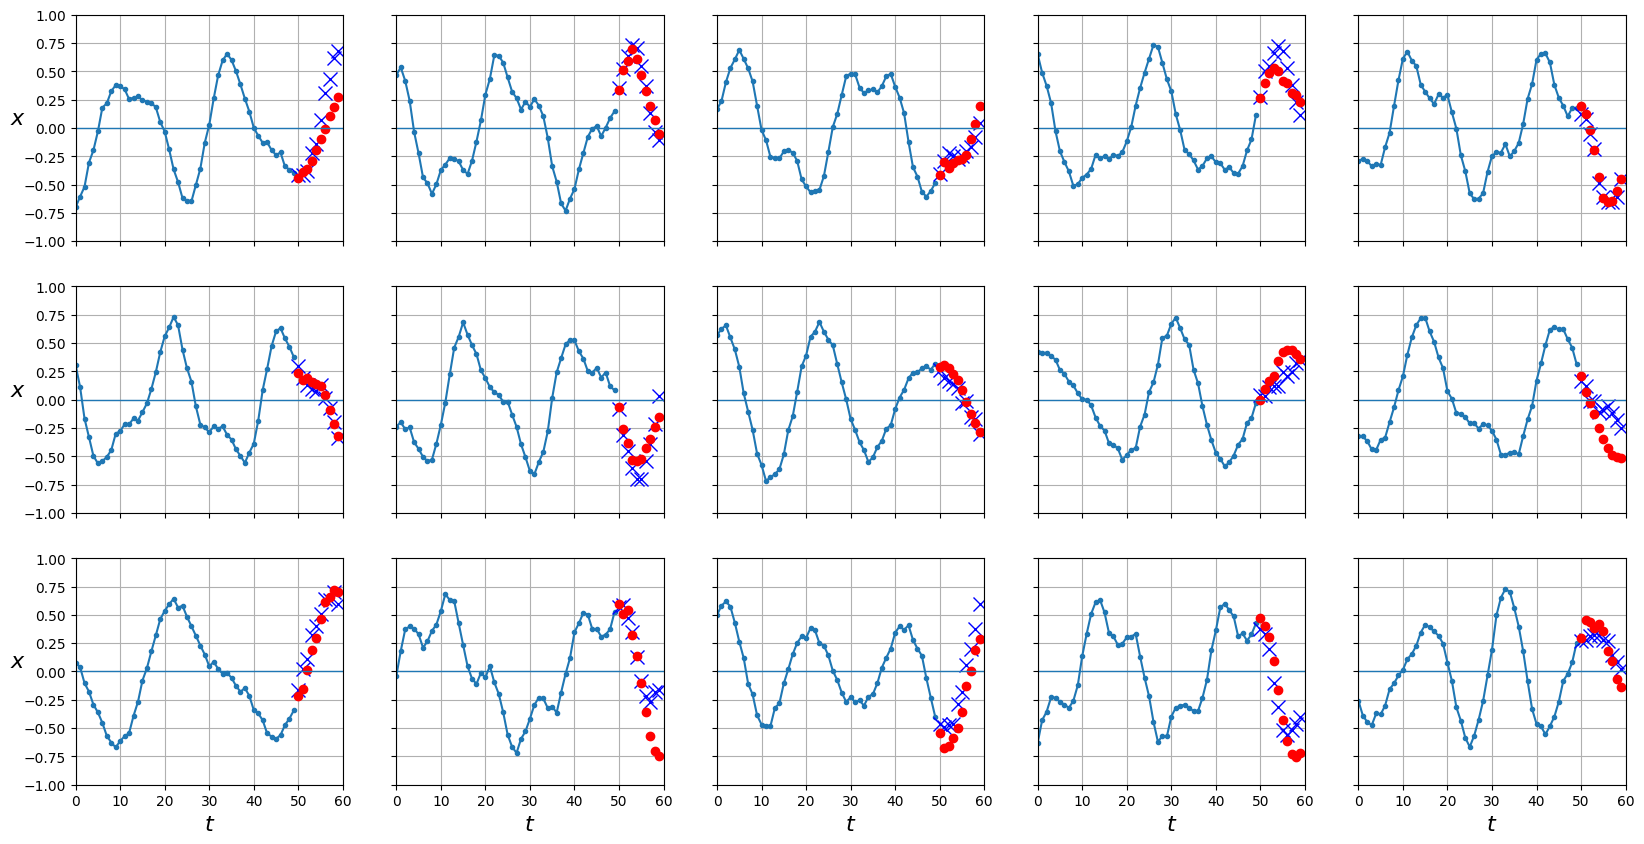

0.020562856

In [ ]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, Y_test, y_pred.cpu().numpy())
mean_squared_error(Y_test, y_pred.cpu())

Como puede ver, nuestro error es mucho menor ya que hemos entrenado nuestra `RNN` a predecir 10 valores en cada instante temporal. Aún así, si observas atentamente la implementación, te darás cuenta que sólo optimizamos nuestra red con las salidas en el último instante. Esto significa que todavía podríamos mejorar más nuestro modelo si optimizamos para cada instante.

In [ ]:
n_steps = 50
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10), dtype=np.float32)
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

Desde el punto de vista de la implementación tenemos que tener en cuenta que nuestra capa `fc` solo conecta las neuronas de la capa oculta en el último paso con las salidas. Para poder optimizar para todos los instantes tenemos que colapsar las dimensiones del *batch* y los instantes temporales de la manera que puedes ver a continuación.

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    # print(x.shape)
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    # print(x.size(-1))

    x_reshaped = x.contiguous().view(-1, x.size(-1))
    # print(x_reshaped.shape)
    # print("##"*30)
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

Como solo nos interesan los últimos 10 valores, calcularemos nuestra métricas solo para estos valores.

In [ ]:
def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")


In [ ]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.03399 loss_last_step 0.01994 val_loss 0.03618 val_loss_last_step 0.02170: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


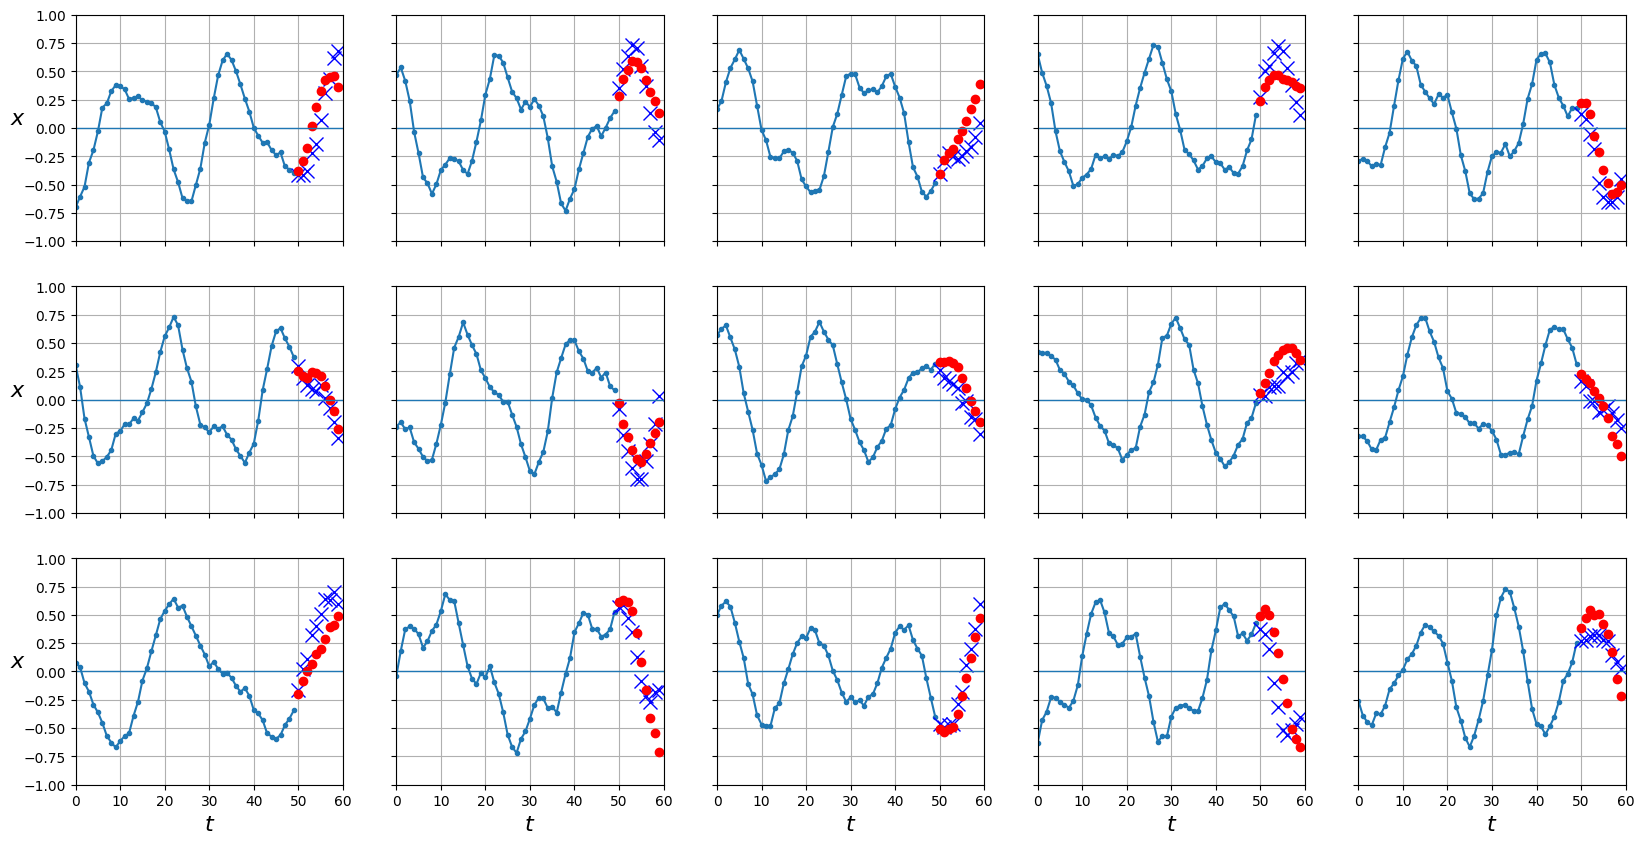

0.021400286

In [ ]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())

Optimizando para cada instante temporal tenemos muchos más gradientes fluyendo durante la etapa de *backpropagation* en vez de sólo desde la última salida (lo cual puede ser problemático ya que a las primeras iteraciones los gradientes que llegan pueden haber desaparecido).

## Intervalos de confianza

En la predicción de series temporales es usual proporcionar intervalos de confianza sobre nuestras predicciones. Existen varias maneras de hacer esto, aquí vamos a ver una técnica simple usando *dropout*, algo de lo que hablamos en [este](https://sensioai.com/blog/031_regularization) post. La clase `torch.nn.RNN` ya tiene implementada la capa *dropout* por lo que solo tenemos que proporcionarle un valor de probabilidad.

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True, dropout=dropout)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [ ]:
rnn = DeepRNN(dropout=0.3)
fit(rnn, dataloader)

loss 0.03604 loss_last_step 0.02254 val_loss 0.03358 val_loss_last_step 0.02045: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Como ya comentamos en el post de regularización la capa *dropout* apagará neuronas de manera aleatoria durante el entrenamiento, sin embargo para sacar las predicciones usaremos todas las neuronas. Para obtener intervalos de confianza vamos a prevenir este comportamiento de manera que cada vez que queramos predicciones lo haremos con una configuración diferente de nuestra red. Finalmente, calcularemos el valor medio de todas las predicciones para obtener una predicción final así como su desviación estándar para calcular los intervalos de confianza.

In [ ]:
def predict(model, dataloader):
    # activar dropout para evaluación !
    model.train() # lo normal aquí es poner model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [ ]:
y_preds = np.stack([predict(rnn, dataloader['test']).cpu().numpy() for sample in range(100)])
y_pred = y_preds.mean(axis=0)
y_pred_std = y_preds.std(axis=0)

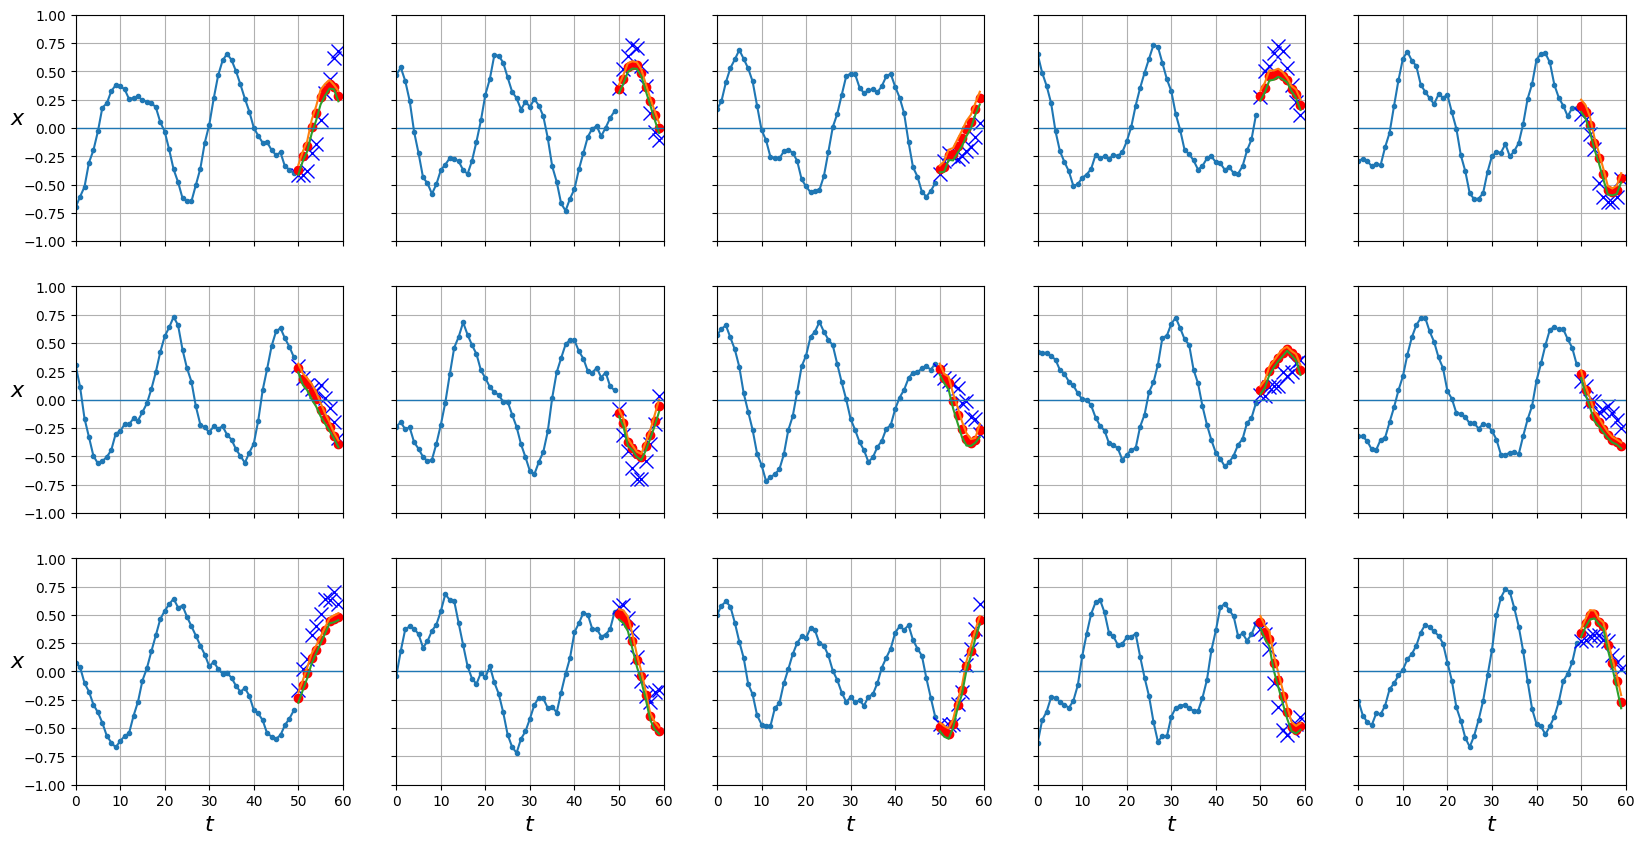

In [ ]:
plot_series(X_test, Y_test[:,-1], y_pred[:,-1], y_pred_std[:, -1])

## Resumen

La predicción de series temporales es muy útil para multitud de aplicaciones, como por ejemplo financieras, médicas, etc. Las `redes neuronales recurrentes` es una arquitectura ideal para el procesado de este tipo de datos (datos secuenciales) y en este post hemos visto como aplicarlas para predecir valores en series temporales. Predecir el último valor nos ha servido para entender mejor el funcionamiento de este tipo de redes, sin embargo el interés estará en ser capaces de predecir muchos valores a la vez (una semana entera, un mes, un año). Hemos visto como entrenar este tipo de redes de manera efectiva así como dar intervalos de confianza sobre nuestras predicciones. Si bien hemos obtenido buenos resultados en nuestros ejemplos, nuestro modelo actual de red recurrente fallará a la hora de trabajar con series temporales más largas (del orden de centenas de instantes temporales). Para resolver este problema veremos modelos de `redes recurrentes` alternativos diseñados para trabajar bien en secuencias largas.